In [17]:
import os
import tarfile
import urllib.request


import scipy.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.backend as K
from tensorflow import keras
from keras import ops
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout, Flatten

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import itertools

# 🔹 Step 1: Load & Explore the Dataset

## 📌 Step 1.1: Download the Dataset

In [18]:
# URL of the dataset
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

# Define download paths
dataset_path = "./102flowers.tgz"
labels_path = "./imagelabels.mat"
data_dir = "./102flowers/"

image_size = (224, 224)

# Function to download dataset
def download_dataset(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, save_path)
        print("Download completed!")

# Download images and labels
download_dataset(dataset_url, dataset_path)
download_dataset(labels_url, labels_path)

# Extract dataset
if not os.path.exists(data_dir):
    print("Extracting dataset...")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall(path=data_dir)
    print("Extraction completed!")

## 📌 Step 1.2: Load Image Labels

In [19]:
# Load image labels
mat = scipy.io.loadmat(labels_path)
labels = mat["labels"][0]  # Extract labels

# Convert labels to zero-indexed format (original is 1-102)
labels = labels - 1

print(f"Total Images: {len(labels)}")
print(f"Unique Classes: {len(set(labels))}")

Total Images: 8189
Unique Classes: 102


## 📌 Step 1.3: Creating Sub-Samples for Smallest Dataset

In [20]:
# Get all image file names
data_dir = '/content/102flowers/jpg/'
image_files = sorted(os.listdir(data_dir))

# Pair image paths with their labels
data = [(os.path.join(data_dir, img), label) for img, label in zip(image_files, labels)]

# Convert unique labels into a sorted list
unique_classes = sorted(list(set(labels)))

# Randomly select 10 classes for Sub-Samples
selected_classes = random.sample(unique_classes, 10)

# Filter dataset to only include selected classes
filtered_data = [(img_path, label) for img_path, label in data if label in selected_classes]

# Create label mapping (assign new indices 0-9)
label_map = {cls: idx for idx, cls in enumerate(selected_classes)}

# Update dataset with new mapped labels
final_data = [(img_path, label_map[label]) for img_path, label in filtered_data]

# Shuffle the final dataset
random.shuffle(final_data)

# Display information
print(f"Selected Classes: {selected_classes}")
print(f"Total Samples in Smallest Dataset: {len(final_data)}")

Selected Classes: [78, 6, 48, 60, 58, 21, 57, 92, 11, 75]
Total Samples in Smallest Dataset: 660


## 📌 Step 1.4: Display Sample Images

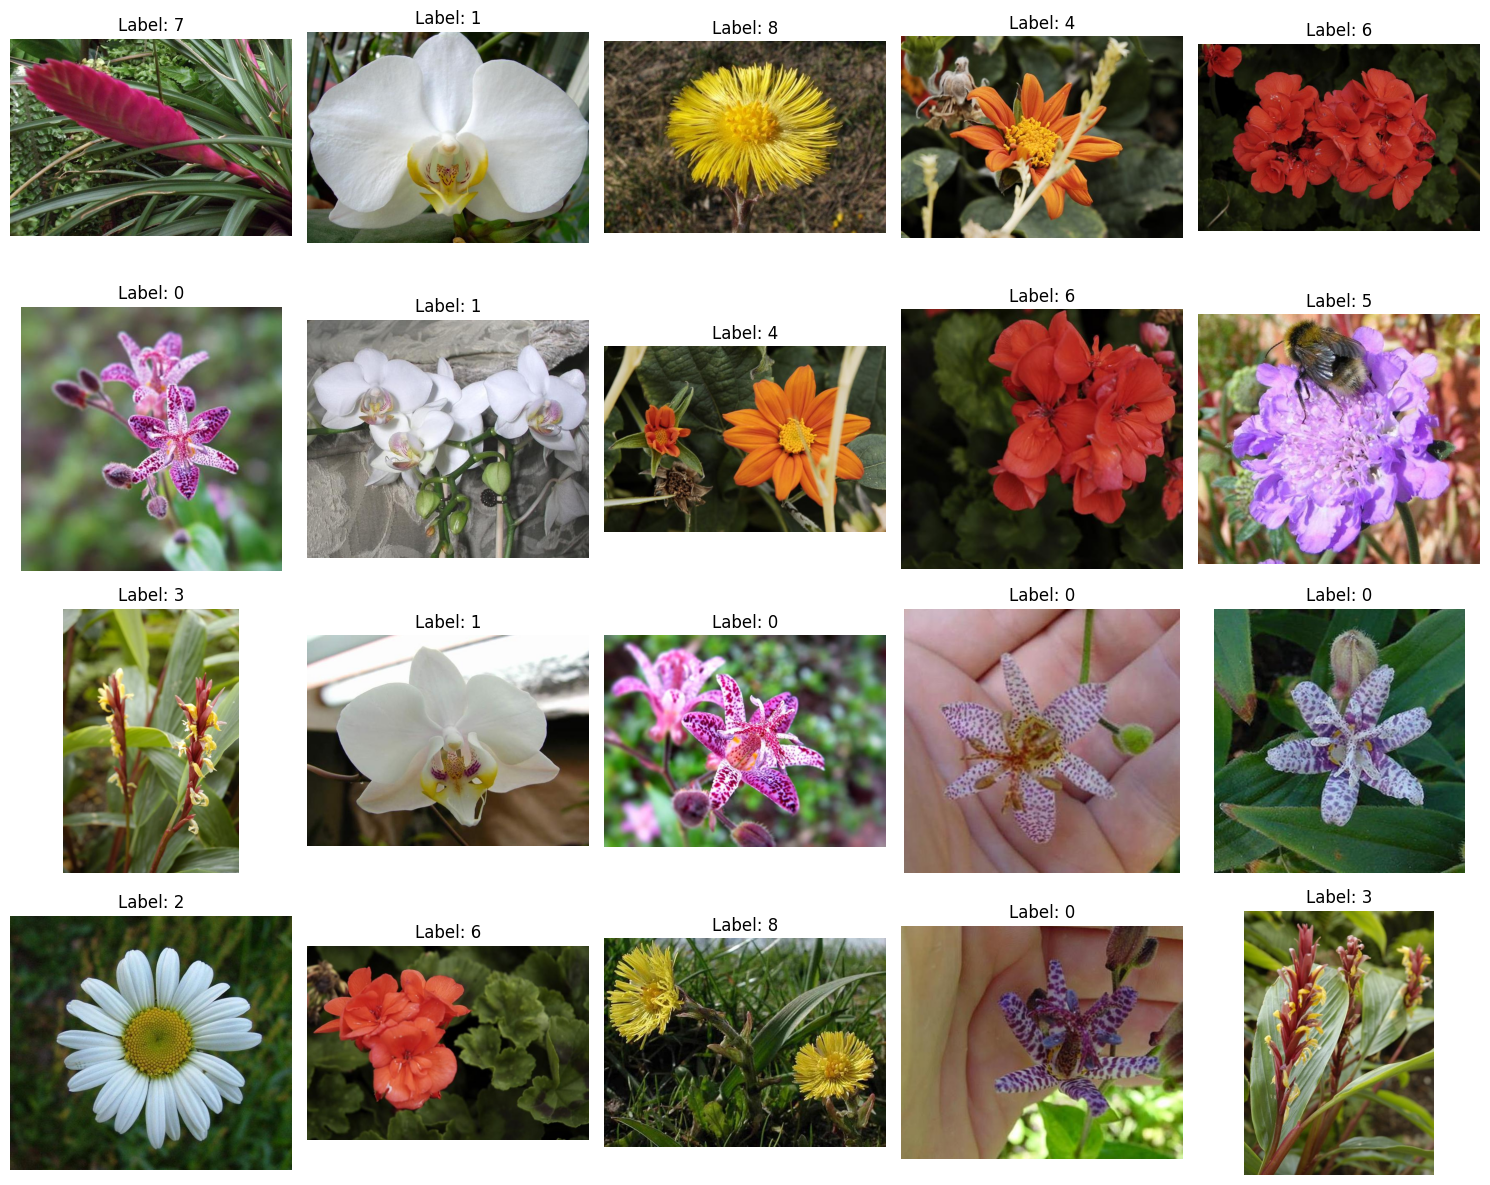

In [21]:
# Select 20 random samples from final_data
sample_images = random.sample(final_data, 20)

# Create a figure with 4 rows and 5 columns
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Loop through selected images and display them
for ax, (image_path, label) in zip(axes.flatten(), sample_images):
    img = Image.open(image_path)  # Open image
    ax.imshow(img)  # Show image
    ax.set_title(f"Label: {label}")  # Display label as title
    ax.axis("off")  # Hide axis

plt.tight_layout()
plt.show()


## 📌 Step 1.5: Providing Support Set and Query Set

In [22]:
# Ensure selected_classes from smallest dataset is excluded
remaining_classes = [cls for cls in unique_classes if cls not in selected_classes]

# Randomly select 3 classes for the 3-way support set
support_classes = random.sample(remaining_classes, 3)

# Select 3 images per class for the support set (keep original labels)
support_set = []
for cls in support_classes:
    cls_images = [img for img in data if img[1] == cls]
    selected_images = random.sample(cls_images, 3)  # Pick 3 images
    support_set.extend(selected_images)

# Select 1 image from each of the 3 support classes for the query set
query_set = []
for cls in support_classes:
    cls_images = [img for img in data if img[1] == cls and img not in support_set]
    if cls_images:
        query_set.append(random.choice(cls_images))  # Pick 1 image per class

# Select 1 more image from one of the 3 support classes to make total 4 images
extra_class = random.choice(support_classes)
extra_images = [img for img in data if img[1] == extra_class and img not in support_set and img not in query_set]

if extra_images:
    query_set.append(random.choice(extra_images))

# Shuffle the sets
# random.shuffle(support_set)
# random.shuffle(query_set)

# Display the Support Set
print("\nSupport Set (3-way, 3-shot):")
for img_path, label in support_set:
    print(f"Image: {img_path}, Original Label: {label}")

# Display the Query Set (now exactly 4 images)
print("\nQuery Set (4 images):")
for img_path, label in query_set:
    print(f"Image: {img_path}, Original Label: {label}")


Support Set (3-way, 3-shot):
Image: /content/102flowers/jpg/image_05746.jpg, Original Label: 12
Image: /content/102flowers/jpg/image_05759.jpg, Original Label: 12
Image: /content/102flowers/jpg/image_05765.jpg, Original Label: 12
Image: /content/102flowers/jpg/image_08030.jpg, Original Label: 101
Image: /content/102flowers/jpg/image_08018.jpg, Original Label: 101
Image: /content/102flowers/jpg/image_08014.jpg, Original Label: 101
Image: /content/102flowers/jpg/image_00129.jpg, Original Label: 76
Image: /content/102flowers/jpg/image_00165.jpg, Original Label: 76
Image: /content/102flowers/jpg/image_00195.jpg, Original Label: 76

Query Set (4 images):
Image: /content/102flowers/jpg/image_05784.jpg, Original Label: 12
Image: /content/102flowers/jpg/image_08029.jpg, Original Label: 101
Image: /content/102flowers/jpg/image_00190.jpg, Original Label: 76
Image: /content/102flowers/jpg/image_08003.jpg, Original Label: 101


## 📌 Step 1.6: Visualizing Support Set and Query Set


Visualizing Support Set:


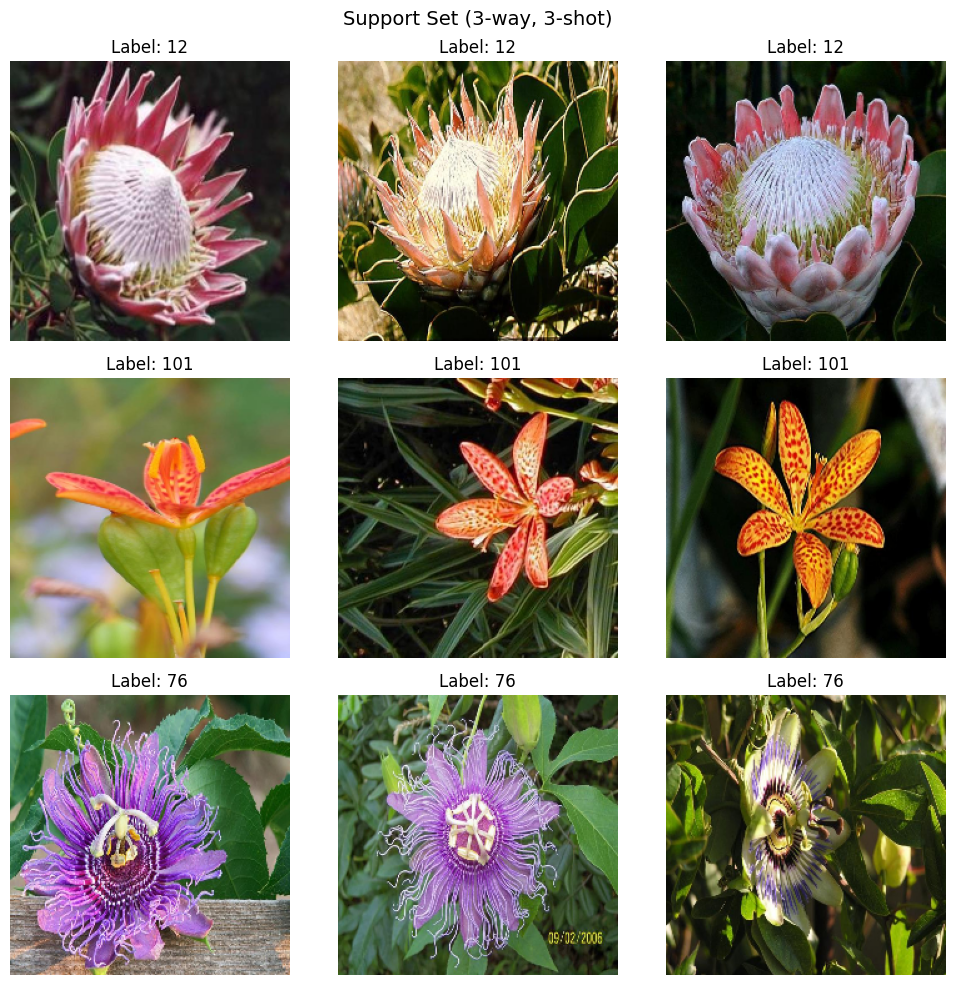


Visualizing Query Set:


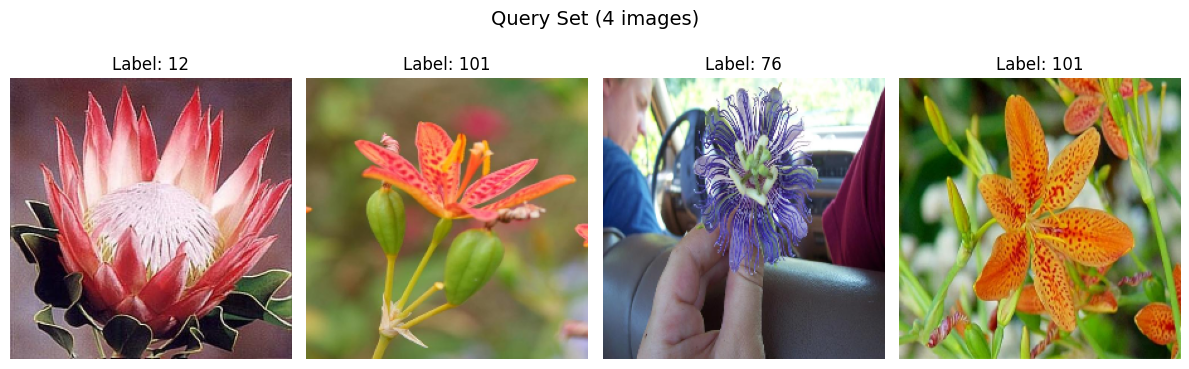

In [23]:
# Function to display images in grid format
def show_images(image_paths, labels, title, rows=1, cols=3, figsize=(10, 5)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=14)

    if rows == 1:  # If only one row, `axes` is 1D
        axes = [axes]

    for idx, (img_path, label) in enumerate(zip(image_paths, labels)):
        img = cv2.imread(img_path)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (224, 224))  # Resize for consistency

        row, col = divmod(idx, cols)  # Determine grid position
        axes[row][col].imshow(img)
        axes[row][col].axis("off")
        axes[row][col].set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

# Extract support set images and labels
support_paths = [img_path for img_path, label in support_set]
support_labels = [label for img_path, label in support_set]

# Extract query set images and labels
query_paths = [img_path for img_path, label in query_set]
query_labels = [label for img_path, label in query_set]

# Show Support Set
print("\nVisualizing Support Set:")
show_images(support_paths, support_labels, title="Support Set (3-way, 3-shot)", rows=3, cols=3, figsize=(10, 10))

# Show Query Set
print("\nVisualizing Query Set:")
show_images(query_paths, query_labels, title="Query Set (4 images)", rows=1, cols=4, figsize=(12, 4))

In [24]:
# Create label mapping (assign 0, 1, 2 to the support classes)
label_map = {cls: idx for idx, cls in enumerate(support_classes)}

# Apply label mapping
mapped_support_set = [(img_path, label_map[label]) for img_path, label in support_set]
mapped_query_set = [(img_path, label_map[label]) for img_path, label in query_set]

# Display the Support Set (after mapping)
print("\nSupport Set (3-way, 3-shot) - Mapped Labels (0,1,2):")
for img_path, label in mapped_support_set:
    print(f"Image: {img_path}, Mapped Label: {label}")

# Display the Query Set (after mapping)
print("\nQuery Set (4 images) - Mapped Labels (0,1,2):")
for img_path, label in mapped_query_set:
    print(f"Image: {img_path}, Mapped Label: {label}")


Support Set (3-way, 3-shot) - Mapped Labels (0,1,2):
Image: /content/102flowers/jpg/image_05746.jpg, Mapped Label: 0
Image: /content/102flowers/jpg/image_05759.jpg, Mapped Label: 0
Image: /content/102flowers/jpg/image_05765.jpg, Mapped Label: 0
Image: /content/102flowers/jpg/image_08030.jpg, Mapped Label: 1
Image: /content/102flowers/jpg/image_08018.jpg, Mapped Label: 1
Image: /content/102flowers/jpg/image_08014.jpg, Mapped Label: 1
Image: /content/102flowers/jpg/image_00129.jpg, Mapped Label: 2
Image: /content/102flowers/jpg/image_00165.jpg, Mapped Label: 2
Image: /content/102flowers/jpg/image_00195.jpg, Mapped Label: 2

Query Set (4 images) - Mapped Labels (0,1,2):
Image: /content/102flowers/jpg/image_05784.jpg, Mapped Label: 0
Image: /content/102flowers/jpg/image_08029.jpg, Mapped Label: 1
Image: /content/102flowers/jpg/image_00190.jpg, Mapped Label: 2
Image: /content/102flowers/jpg/image_08003.jpg, Mapped Label: 1


# 🔹 Step 2: Feature Extraction using ResNet50

In [25]:
# Load ResNet50 and freeze layers
def build_feature_extractor():
    """Create a ResNet50 feature extractor with frozen layers."""
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers

    # Add a global pooling layer and a dense layer for embeddings
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    # x = Dense(256, activation="relu")(x)  # Trainable layer
    x = Dense(128, activation="relu")(x)  # Trainable layer
    # x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)  # Trainable layer

    model = Model(inputs=base_model.input, outputs=x)
    return model
'''
def build_feature_extractor(fine_tune=False):
    """Create a ResNet50 feature extractor, optionally fine-tuning the last layers."""
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    if fine_tune:
        # Unfreeze the last few layers
        for layer in base_model.layers[-2:]:  # Unfreezing last 2 layers
            layer.trainable = True
    else:
        # Freeze all layers
        for layer in base_model.layers:
            layer.trainable = False

    # Add a global pooling layer and a dense embedding layer
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dense(64, activation="relu")(x)  # Trainable embedding layer

    model = Model(inputs=base_model.input, outputs=x)
    return model
'''

feature_extractor = build_feature_extractor()
feature_extractor.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,858,240 (91.01 MB)

 Trainable params: 270,528 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 🔹 Step 3: Creating Image Pairs for Siamese Network

In [26]:
def create_pairs(images, labels):
    pairs = []
    pair_labels = []
    num_classes = len(np.unique(labels))

    # Create pairs
    for idx in range(len(images)):
        current_img = images[idx]
        current_label = labels[idx]

        # Positive pair
        pos_idx = np.random.choice(np.where(labels == current_label)[0])
        pos_img = images[pos_idx]
        pairs.append([current_img, pos_img])
        pair_labels.append(1)

        # Negative pair
        neg_label = (current_label + np.random.randint(1, num_classes)) % num_classes
        neg_idx = np.random.choice(np.where(labels == neg_label)[0])
        neg_img = images[neg_idx]
        pairs.append([current_img, neg_img])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

In [27]:
def preprocess_image(image_path):
    """Load and preprocess image."""
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

# Load images and labels into NumPy arrays
X = np.array([preprocess_image(img_path) for img_path, _ in final_data])
y = np.array([label for _, label in final_data])

# Create image pairs for training
pairs, pair_labels = create_pairs(X, y)
del X, y

# 🔹 Step 4: Data Splitting

In [28]:

X_a = pairs[:, 0]
X_b = pairs[:, 1]
del pairs
X_a = np.stack(X_a, axis=0)
X_b = np.stack(X_b, axis=0)
'''
# Split into training and validation sets
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, pair_labels, test_size=0.2, random_state=42
)

del pairs, pair_labels
'''
X_train_a, X_val_a, X_train_b, X_val_b, y_train, y_val = train_test_split(X_a, X_b, pair_labels, test_size=0.2, random_state=42)
del X_a, X_b, pair_labels

# 🔹 Step 5: Siamese Network Model

In [29]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    """Contrastive Loss function with numerical stability."""
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0)  # Ensure y_pred is not too close to zero
    squared_pred = K.square(y_pred)
    margin_squared = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * squared_pred + (1 - y_true) * margin_squared)
'''
def euclidean_distance(vectors):
    """Compute Euclidean distance with numerical stability."""
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True) + K.epsilon())
'''

def euclidean_distance(vectors):
    """Compute Euclidean distance with numerical stability."""
    x, y = vectors
    return K.expand_dims(K.sqrt(K.sum(K.square(x - y), axis=-1) + K.epsilon()), axis=-1)


In [30]:
def build_siamese_network():
    """Create a Siamese network with contrastive loss."""
    input_shape = (224, 224, 3)

    # Input layers
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Shared feature extractor
    feature_extractor = build_feature_extractor()
    encoded_a = feature_extractor(input_a)
    encoded_b = feature_extractor(input_b)

    # Distance layer
    distance = Lambda(euclidean_distance, output_shape=(1,))([encoded_a, encoded_b])


    # Model
    model = Model(inputs=[input_a, input_b], outputs=distance)

    model.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(learning_rate=1e-4))
    return model

# Create and compile the model
siamese_model = build_siamese_network()
siamese_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 64)             │     23,858,240 │ input_layer_5[0][0],   │
│                           │                        │                │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_4[0][0],    │
│                           │                        │                │ functional_4[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,858,240 (91.01 MB)

 Trainable params: 270,528 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 📌 Step 5.1: model Training

In [31]:
# Train the model
history = siamese_model.fit(
    [X_train_a, X_train_b],
    y_train,
    validation_data=([X_val_a, X_val_b], y_val),
    epochs=30,
    batch_size=32
)
'''
# Train the model
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    epochs=20,
    batch_size=32
)
'''

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 636ms/step - loss: 0.2459 - val_loss: 0.2478
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - loss: 0.2235 - val_loss: 0.2382
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - loss: 0.2202 - val_loss: 0.2311
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - loss: 0.2019 - val_loss: 0.2227
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - loss: 0.2065 - val_loss: 0.2182
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.1996 - val_loss: 0.2125
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - loss: 0.1973 - val_loss: 0.2087
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - loss: 0.1899 - val_loss: 0.2068
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - loss: 0.1844 - val_loss: 0.2049
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.1733 - val_loss: 0.2021
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.1726 - val_loss: 0.1995
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 2

'\n# Train the model\nhistory = siamese_model.fit(\n    [train_pairs[:, 0], train_pairs[:, 1]],\n    train_labels,\n    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),\n    epochs=20,\n    batch_size=32\n)\n'

# 📌Step 5.2: Fine Tuning

In [32]:
'''
# Unfreeze the last few layers of ResNet50 inside the trained model
for layer in siamese_model.layers[2].layers[-2:]:  # Feature extractor is the 3rd layer (index 2)
    layer.trainable = True

# Compile again with a lower learning rate
siamese_model.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(learning_rate=1e-5))
'''
# Print model summary to verify trainable layers
siamese_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 64)             │     23,858,240 │ input_layer_5[0][0],   │
│                           │                        │                │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_4[0][0],    │
│                           │                        │                │ functional_4[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,399,298 (93.08 MB)

 Trainable params: 270,528 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 541,058 (2.06 MB)

In [33]:
# Extract support images and labels
support_images = np.array([preprocess_image(img_path) for img_path, _ in mapped_support_set])
support_labels = np.array([label for _, label in mapped_support_set])

# Generate pairs from support set
support_pairs, support_pair_labels = create_pairs(support_images, support_labels)

# Extract paired inputs
support_a = np.stack(support_pairs[:, 0], axis=0)
support_b = np.stack(support_pairs[:, 1], axis=0)

In [34]:
# Fine-tune using the support set
history = siamese_model.fit(
    [support_a, support_b],
    support_pair_labels,
    epochs=10,  # Fewer epochs to avoid overfitting
    batch_size=8,  # Smaller batch size due to limited data
    verbose=1
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.1735
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.1587
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1403
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1111
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0804
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0805
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0566
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0396
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0412
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0269


# 🔹 Step 6: Inference Phase

# 📌 Step 6.1: Preparing Support and Query Sets

In [35]:
mapped_support_set_path = [mapped_support_set_path for mapped_support_set_path, _ in mapped_support_set]
mapped_support_set_label = [mapped_support_set_label for  _, mapped_support_set_label in mapped_support_set]
mapped_query_set_path =  [mapped_query_set_path for mapped_query_set_path, _ in mapped_query_set]

In [36]:
def prepare_manual_support_set(support_image_paths, support_labels):
    support_images = [preprocess_image(img) for img in support_image_paths]
    support_images = np.stack(support_images)
    support_labels = np.array(support_labels)
    return support_images, support_labels

support_images, support_labels = prepare_manual_support_set(mapped_support_set_path, mapped_support_set_label)
print(f"Support Images Shape: {support_images.shape}, Labels Shape: {support_labels.shape}")

Support Images Shape: (9, 224, 224, 3), Labels Shape: (9,)


In [37]:
def prepare_query_images(query_image_paths):
    print(query_image_paths)
    query_images = [preprocess_image(img) for img in query_image_paths]
    return np.stack(query_images)

query_images = prepare_query_images(mapped_query_set_path)
print(f"Query Images Shape: {query_images.shape}")

['/content/102flowers/jpg/image_05784.jpg', '/content/102flowers/jpg/image_08029.jpg', '/content/102flowers/jpg/image_00190.jpg', '/content/102flowers/jpg/image_08003.jpg']
Query Images Shape: (4, 224, 224, 3)


## 📌 Step 6.2: Prediction Phase

In [38]:
def predict_query_image(siamese_net, query_image, support_images, support_labels):
    """
    Predict the class of a single query image by finding the closest support image.

    Args:
    - siamese_net: Trained Siamese network model.
    - query_image: A single image of shape (IMG_SIZE, IMG_SIZE, 3).
    - support_images: Support set images (NUM_SHOTS * NUM_WAYS, IMG_SIZE, IMG_SIZE, 3).
    - support_labels: Corresponding class labels for support images.

    Returns:
    - Predicted class label for the query image.
    """
    distances = []

    # Expand dimensions to match model input shape
    query_image = np.expand_dims(query_image, axis=0)  # Shape (1, IMG_SIZE, IMG_SIZE, 3)

    for i, support_image in enumerate(support_images):
        support_image = np.expand_dims(support_image, axis=0)  # Shape (1, IMG_SIZE, IMG_SIZE, 3)

        # Predict distance using the Siamese network
        distance = siamese_net.predict([query_image, support_image])[0][0]
        # print('distance:', distance)
        distances.append((distance, support_labels[i]))

    # Find the support image with the smallest distance
    distances.sort()  # Sort by distance (ascending)
    best_match_label = distances[0][1]  # Get the class of the closest match

    return best_match_label, distances  # Returning distances for debugging


In [39]:
predicted_labels = []
siamese_net = siamese_model
for i, query_image in enumerate(query_images):
    predicted_label, distances = predict_query_image(siamese_net, query_image, support_images, support_labels)
    predicted_labels.append(predicted_label)
    print(f"Query Image {i+1} classified as Class {predicted_label}, Distances: {distances}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Query Image 1 classified as Class 0, Distances: [(0.48882958, 0), (0.4895079, 0), (0.5242764, 0), (0.74680597, 1), (0.80780536, 2), (0.9599493, 2), (0.9781163, 1), (0.9896617, 2), (1.1730494, 1)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Query Image 2 classified as Class 1, Distances: [(0.09380442, 1), (0.35105002, 1), (0.47695804, 2), (0.50312495, 2), (0.64

In [40]:
print("Predicted Labels for Query Set:", predicted_labels)

Predicted Labels for Query Set: [0, 1, 2, 2]


## 📌 Step 6.3: Comparing Predicted label and Actual Class

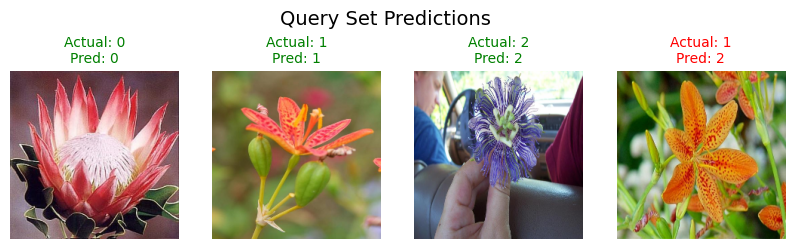

In [41]:
# Number of query images
num_queries = len(mapped_query_set)

# Set up figure size dynamically
plt.figure(figsize=(num_queries * 2.5, 3))

# Iterate over query images and their predicted labels
for i, ((img_path, actual_label), predicted_label) in enumerate(zip(mapped_query_set, predicted_labels)):
    img = cv2.imread(img_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to match Omniglot standard size

    # Define title color (green for correct, red for incorrect)
    title_color = "green" if actual_label == predicted_label else "red"

    plt.subplot(1, num_queries, i + 1)  # Create subplot for each query image
    plt.imshow(img)
    plt.title(f'Actual: {actual_label}\nPred: {predicted_label}', fontsize=10, color=title_color)
    plt.axis('off')

plt.suptitle("Query Set Predictions", fontsize=14)
plt.show()
